In [1]:
import os

# Path to your dataset (shown in your Kaggle screenshot)
root_dir = "/kaggle/input/pcb-defects/"

# Path to save trained models or logs
output_dir = "/kaggle/working/"

print("Dataset path:", root_dir)
print("Output path:", output_dir)


Dataset path: /kaggle/input/pcb-defects/
Output path: /kaggle/working/


In [2]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:0000:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Explore Dataset

In [4]:
dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED
/kaggle/input/pcb-defects/PCB_DATASET/Annotations
/kaggle/input/pcb-defects/PCB_DATASET/images
/kaggle/input/pcb-defects/PCB_DATASET/rotation
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Mouse_bite
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Spur
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Open_circuit
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Short
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Missing_hole
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Spurious_copper
/kaggle/input/pcb-defects/PCB_DATASET/images/Mouse_bite
/kaggle/input/pcb-defects/PCB_DATASET/images/Spur
/kaggle/input/pcb-defects/PCB_DATASET/images/Open_circuit
/kaggle/input/pcb-defects/PCB_DATASET/images/Short
/kaggle/input/pcb-defects/PCB_DATASET/images/Missing_hole
/kaggle/input/pcb-defects/PCB_DATASET/images/Spurious_copper
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Missing_hole_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotati

In [5]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [6]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


# Create annotaton dataset

In [7]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [8]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [9]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_mouse_bite_11.jpg,3034,1586,mouse_bite,1199,966,1234,1004
1,01_mouse_bite_11.jpg,3034,1586,mouse_bite,2042,755,2073,786
2,01_mouse_bite_11.jpg,3034,1586,mouse_bite,1472,607,1507,639
3,01_mouse_bite_17.jpg,3034,1586,mouse_bite,2168,854,2200,887
4,01_mouse_bite_17.jpg,3034,1586,mouse_bite,1513,919,1545,957


# Visualization

In [10]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [11]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image


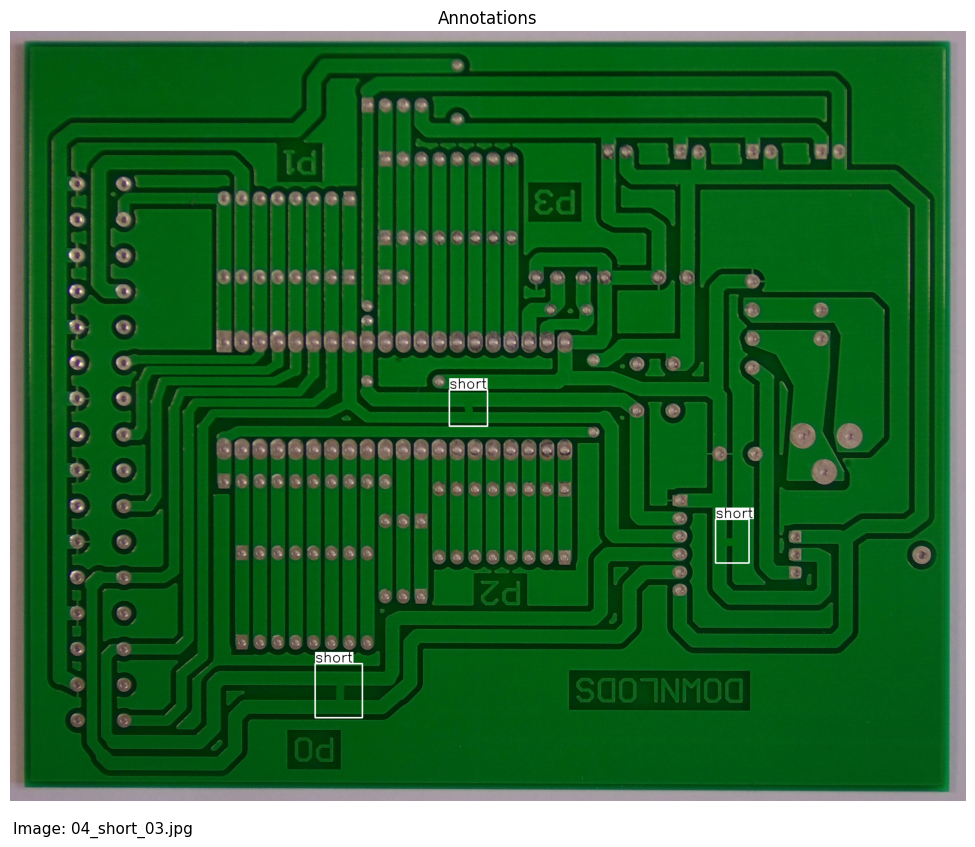

In [12]:
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

# Dataset preprocessing

In [13]:
def resize_images(input_dir, output_dir, target_size=(768, 768)):
    os.makedirs(output_dir, exist_ok=True)

    target_w, target_h = target_size

    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith('.jpg'):
                image_path = os.path.join(root, file)
                img = cv2.imread(image_path)

                h, w = img.shape[:2]
                scale = min(target_w / w, target_h / h)

                new_w = int(w * scale)
                new_h = int(h * scale)

                resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

                canvas = np.full((target_h, target_w, 3), 114, dtype=np.uint8)
                canvas[:new_h, :new_w] = resized

                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, canvas)


# YOU MUST SAVE IN A WRITABLE DIRECTORY
resized_img_dir = "/kaggle/working/images_resized"

resize_images(images_dir, resized_img_dir)


In [14]:
def resize_annotations(annot_df, target_size=(768, 768)):
    target_w, target_h = target_size
    all_data = []

    for _, row in annot_df.iterrows():
        orig_w = row['width']
        orig_h = row['height']

        # same scale factor used in resize_images()
        scale = min(target_w / orig_w, target_h / orig_h)

        # no padding offset because we place image at top-left (0,0)
        pad_x = 0
        pad_y = 0

        # apply scale
        xmin = int(row['xmin'] * scale + pad_x)
        ymin = int(row['ymin'] * scale + pad_y)
        xmax = int(row['xmax'] * scale + pad_x)
        ymax = int(row['ymax'] * scale + pad_y)

        all_data.append({
            'filename': row['filename'],
            'width': target_w,
            'height': target_h,
            'class': row['class'],
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return pd.DataFrame(all_data)


annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_mouse_bite_11.jpg,768,768,mouse_bite,303,244,312,254
1,01_mouse_bite_11.jpg,768,768,mouse_bite,516,191,524,198
2,01_mouse_bite_11.jpg,768,768,mouse_bite,372,153,381,161
3,01_mouse_bite_17.jpg,768,768,mouse_bite,548,216,556,224
4,01_mouse_bite_17.jpg,768,768,mouse_bite,382,232,391,242


# Split dataset

In [15]:
# Create the output directory (MUST BE IN kaggle/working/)
output_dir = "/kaggle/working/output"
os.makedirs(output_dir, exist_ok=True)

print("Output directory:", output_dir)


Output directory: /kaggle/working/output


In [16]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>
def convert_to_yolo_labels(annotation_df, classes, target_size=(768, 768)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)


In [17]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'w') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

# K-Fold Cross Validation

In [18]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [19]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [20]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [21]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

/tmp/ipykernel_36/2627102905.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`


,0,1,2,3,4,5
01_missing_hole_01,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_02,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_03,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_04,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_05,4.0,0.0,0.0,0.0,0.0,0.0


In [22]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [23]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

/tmp/ipykernel_36/3825890032.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
/tmp/ipykernel_36/3825890032.py:6: FutureWarning: ChainedAssignmentError: behaviour will cha

In [24]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

,0,1,2,3,4,5
split_1,0.404192,0.574751,0.35241,0.587629,0.540984,0.503165
split_2,0.493631,0.54902,0.501672,0.430341,0.477987,0.678445
split_3,0.617241,0.390029,0.681648,0.490323,0.48265,0.353276


In [25]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [26]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [27]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

# Model Training

In [28]:
from ultralytics import YOLO
import torch, gc

results = {}

model_name  = "yolov8m.pt"
batch       = 8
epochs      = 180
imgsz       = 768
save_period = 5
project     = "pcb_m_sota_v8_clean_fixed"

for k in range(ksplit):
    print(f"\n🔵 TRAINING FOLD {k+1}/{ksplit}\n")

    model = YOLO(model_name)
    dataset_yaml = ds_yamls[k]

    model.train(
        data=dataset_yaml,
        epochs=epochs,
        batch=batch,
        imgsz=imgsz,

        # ---- LEARNING ----
        lr0=0.002,
        lrf=0.0001,
        momentum=0.95,
        weight_decay=0.0005,
        warmup_epochs=4,
        warmup_momentum=0.9,

        # ---- LOSS ----
        box=7.0,
        cls=1.0,

        # ---- AUGMENTATION ----
        mosaic=0.8,
        mixup=0.0,
        erasing=0.35,
        copy_paste=0.15,
        auto_augment="randaugment",
        hsv_h=0.02,
        hsv_s=0.8,
        hsv_v=0.5,
        translate=0.12,
        scale=0.55,
        fliplr=0.5,
        perspective=0.0005,

        # ---- DETECTION ----
        multi_scale=False,   # 🔥 IMPORTANT FIX
        iou=0.2,
        conf=0.001,

        # ---- SYSTEM ----
        amp=True,
        workers=0,           # 🔥 IMPORTANT FIX
        cache=False,

        # ---- SAVE / LOG ----
        project=project,
        name=f"fold_{k}",
        save_period=save_period,
        verbose=True,
    )

    results[k] = model.metrics

    del model
    gc.collect()
    torch.cuda.empty_cache()



🔵 TRAINING FOLD 1/3

Ultralytics 8.3.232 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=0.001, copy_paste=0.15, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/output/3fold_crossval/split_1/split_1_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=180, erasing=0.35, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.8, hsv_v=0.5, imgsz=768, int8=False, iou=0.2, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.95, mosaic=0.8, multi_scale=False, name=fold_0, nbs=64, nms=False, opset=None, optimize=False, optimizer=aut

2025-11-26 16:13:03,312	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-26 16:13:03,982	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

In [38]:
from ultralytics import YOLO

# Add '_fixed' to the path
best_model = YOLO("/kaggle/working/pcb_m_sota_v8_clean_fixed/fold_2/weights/best.pt")
best_model.val(imgsz=768, augment=True)

Ultralytics 8.3.232 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3189.5±672.0 MB/s, size: 189.6 KB)
val: Scanning /kaggle/working/output/3fold_crossval/split_3/val/labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 219/219 340.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 1.2it/s 11.5s0.6s
                   all        219        923      0.954      0.956       0.97      0.522
          missing_hole         41        179      0.994          1      0.995      0.589
            mouse_bite         30        133      0.985      0.992      0.995      0.542
          open_circuit         46        182      0.971      0.928      0.975       0.48
                 short         37        152      0.921      0.961      0.955      0.515
       

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fd49a316c80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

# Model

In [41]:
pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 1.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab_widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
Note: you may need to restart the kernel to use updated packages.


In [44]:
result = model.train(
    data=data_path,
    epochs=epochs,
    batch=batch,
    imgsz=imgsz,

    # ---------- Optimized learning ----------
    lr0=0.002,
    lrf=0.0001,
    momentum=0.95,
    weight_decay=0.0005,
    warmup_epochs=4,
    warmup_momentum=0.9,

    # ---------- Loss ----------
    box=7.0,
    cls=1.0,

    # ---------- Augmentation ----------
    mosaic=0.9,
    mixup=0.0,
    erasing=0.35,
    copy_paste=0.15,
    auto_augment="randaugment",
    hsv_h=0.02,
    hsv_s=0.8,
    hsv_v=0.5,
    translate=0.12,
    scale=0.55,
    fliplr=0.5,
    perspective=0.0005,

    # ---------- Detection ----------
    iou=0.2,
    conf=0.001,

    # ---------- Kaggle-safe ----------
    amp=True,
    device=0,
    cache=False,

    # ---------- Logging ----------
    project=project,
    name="run_m_sota",
    save_period=save_period,
    verbose=verbose,
)


Ultralytics 8.3.232 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=0.001, copy_paste=0.15, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=180, erasing=0.35, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.8, hsv_v=0.5, imgsz=832, int8=False, iou=0.2, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.95, mosaic=0.9, multi_scale=False, name=run_m_sota, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0005, plots=

In [46]:
results_dir = "/kaggle/working/pcb_m_single_sota/run_m_sota"

# SAVE RESULTS HERE (WRITEABLE)
dest_results_dir = "/kaggle/working/results"

os.makedirs(dest_results_dir, exist_ok=True)

shutil.copytree(results_dir, dest_results_dir, dirs_exist_ok=True)


'/kaggle/working/results'

In [47]:
results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df.columns = results_df.columns.str.strip()
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()
results_df.head()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,45.5130,2.72949,14.65170,1.51660,0.65516,0.56197,0.60802,0.22599,2.19004,4.77244,1.33387,0.000247,0.000247,0.000247
1,2,90.9272,1.99559,4.15864,1.15254,0.87436,0.76275,0.79880,0.32097,1.83950,2.44429,1.17908,0.000494,0.000494,0.000494
2,3,136.1130,1.90613,3.29238,1.11362,0.84886,0.79584,0.82592,0.37728,1.75856,2.47080,1.12848,0.000739,0.000739,0.000739
3,4,181.2270,1.84800,2.95272,1.09076,0.77664,0.77586,0.82620,0.35196,1.86294,2.87663,1.17031,0.000980,0.000980,0.000980
4,5,226.0810,1.85695,2.77864,1.08915,0.91392,0.88478,0.89614,0.36611,1.83383,2.04803,1.13141,0.000978,0.000978,0.000978


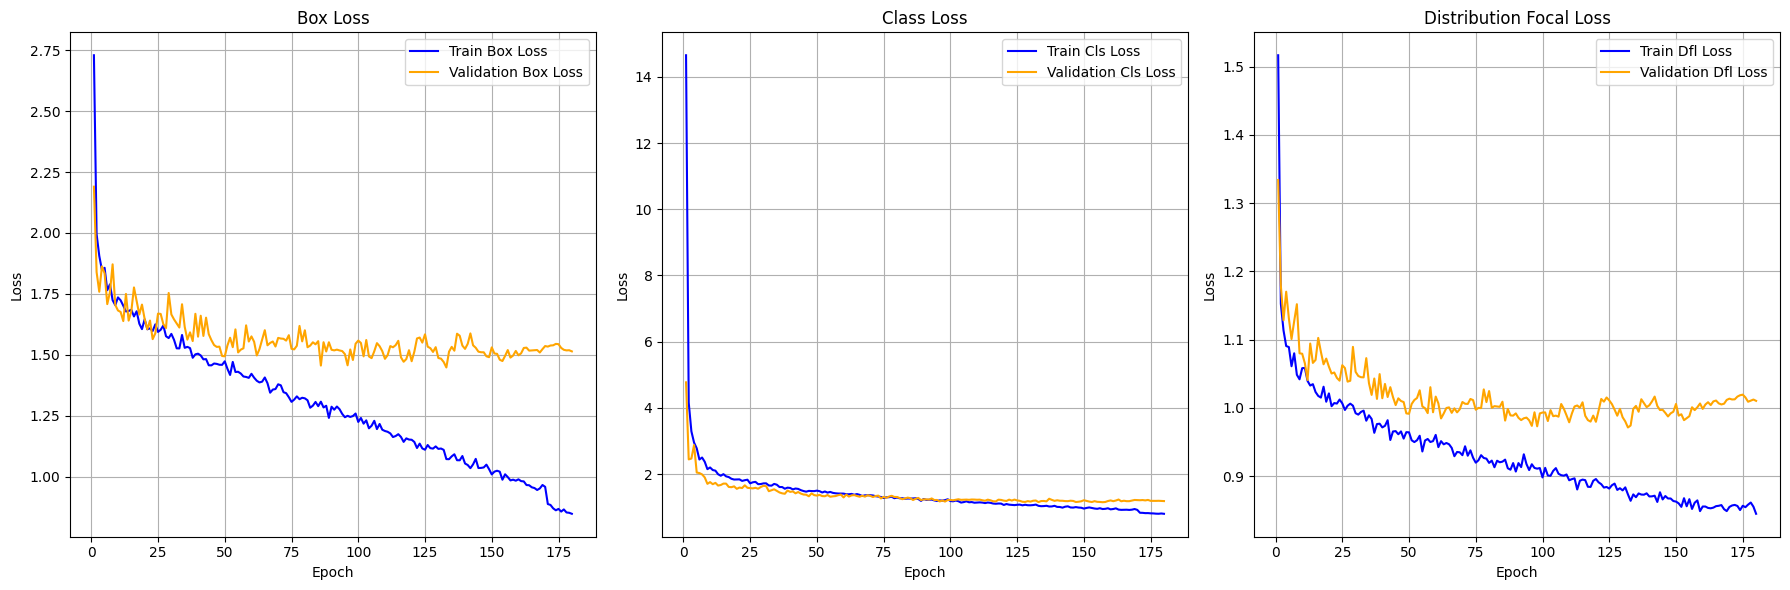

In [48]:
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot box loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot cls loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plot dfl loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Predict on test data

In [73]:
# ------------------------------
# Load the trained model
# ------------------------------
train_dir = "/kaggle/working/pcb_m_single_sota/run_m_sota"
best_model_path = os.path.join(train_dir, "weights/best.pt")
model = YOLO(best_model_path)

print("Using model:", best_model_path)

# ------------------------------
# Run inference on val images
# ------------------------------
test_data_dir = os.path.join(output_dir, "images/val")

metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)

Using model: /kaggle/working/pcb_m_single_sota/run_m_sota/weights/best.pt

image 1/34 /kaggle/working/output/images/val/01_mouse_bite_19.jpg: 640x640 1 mouse_bite, 15.3ms
image 2/34 /kaggle/working/output/images/val/01_short_11.jpg: 640x640 4 shorts, 15.4ms
image 3/34 /kaggle/working/output/images/val/01_spur_16.jpg: 640x640 1 spur, 15.4ms
image 4/34 /kaggle/working/output/images/val/01_spur_19.jpg: 640x640 (no detections), 15.4ms
image 5/34 /kaggle/working/output/images/val/01_spurious_copper_11.jpg: 640x640 3 spurious_coppers, 14.5ms
image 6/34 /kaggle/working/output/images/val/04_missing_hole_12.jpg: 640x640 3 missing_holes, 14.5ms
image 7/34 /kaggle/working/output/images/val/04_mouse_bite_01.jpg: 640x640 3 mouse_bites, 14.6ms
image 8/34 /kaggle/working/output/images/val/04_mouse_bite_17.jpg: 640x640 3 mouse_bites, 14.5ms
image 9/34 /kaggle/working/output/images/val/04_open_circuit_10.jpg: 640x640 2 open_circuits, 14.4ms
image 10/34 /kaggle/working/output/images/val/04_spur_13.jpg: 

In [77]:
predict_dir = "/kaggle/working/runs/detect/predict"

# -----------------------------------
# Save predictions safely in working/
# -----------------------------------
dest_predict_dir = "/kaggle/working/results/predict2"

os.makedirs(dest_predict_dir, exist_ok=True)

shutil.copytree(predict_dir, dest_predict_dir, dirs_exist_ok=True)

print("✔ Predictions saved to:", dest_predict_dir)

best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join(output_dir, 'images/val')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)

✔ Predictions saved to: /kaggle/working/results/predict2

image 1/34 /kaggle/working/output/images/val/01_mouse_bite_19.jpg: 640x640 1 mouse_bite, 15.3ms
image 2/34 /kaggle/working/output/images/val/01_short_11.jpg: 640x640 4 shorts, 15.4ms
image 3/34 /kaggle/working/output/images/val/01_spur_16.jpg: 640x640 1 spur, 15.4ms
image 4/34 /kaggle/working/output/images/val/01_spur_19.jpg: 640x640 (no detections), 15.4ms
image 5/34 /kaggle/working/output/images/val/01_spurious_copper_11.jpg: 640x640 3 spurious_coppers, 15.4ms
image 6/34 /kaggle/working/output/images/val/04_missing_hole_12.jpg: 640x640 3 missing_holes, 15.5ms
image 7/34 /kaggle/working/output/images/val/04_mouse_bite_01.jpg: 640x640 3 mouse_bites, 15.5ms
image 8/34 /kaggle/working/output/images/val/04_mouse_bite_17.jpg: 640x640 3 mouse_bites, 14.4ms
image 9/34 /kaggle/working/output/images/val/04_open_circuit_10.jpg: 640x640 2 open_circuits, 14.3ms
image 10/34 /kaggle/working/output/images/val/04_spur_13.jpg: 640x640 2 spurs, 

In [78]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    original_annot = []

    for yolo_label in yolo_labels:
        # Extract original width and height from annotation DataFrame
        original_size = annot_df.loc[annot_df['filename'] == image_name, ['width', 'height']].iloc[0]
        original_width, original_height = original_size['width'], original_size['height']

        # Extract YOLO label components
        class_index, x_center, y_center, bbox_width, bbox_height, confidence = yolo_label

        # Scale bounding box coordinates and dimensions to original size
        original_x_center = x_center * original_width
        original_y_center = y_center * original_height
        original_bbox_width = bbox_width * original_width
        original_bbox_height = bbox_height * original_height

        # Calculate original bounding box coordinates
        original_x_min = original_x_center - original_bbox_width / 2
        original_y_min = original_y_center - original_bbox_height / 2
        original_x_max = original_x_center + original_bbox_width / 2
        original_y_max = original_y_center + original_bbox_height / 2

        # Append original annotation to list
        original_annot.append({
            'filename': image_name,
            'width': int(original_width),
            'height': int(original_height),
            'class': classes[int(class_index)],
            'xmin': int(original_x_min),
            'ymin': int(original_y_min),
            'xmax': int(original_x_max),
            'ymax': int(original_y_max),
            'confidence': confidence
        })

    return pd.DataFrame(original_annot)

In [93]:
def read_yolo_labels_from_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            values = [float(value) for value in values]
            labels.append(values)
    return labels

file_path = os.path.join('/kaggle/working/runs/detect/predict4', 'labels/11_missing_hole_02.txt')
yolo_labels = read_yolo_labels_from_file(file_path)

yolo_labels

[[0.0, 0.240219, 0.572884, 0.0314272, 0.0358259, 0.825116],
 [0.0, 0.643365, 0.574141, 0.0321873, 0.0389853, 0.823905],
 [0.0, 0.464104, 0.439662, 0.0301792, 0.0343011, 0.81944],
 [0.0, 0.713145, 0.835836, 0.0312731, 0.0371143, 0.812066],
 [0.0, 0.528167, 0.115692, 0.0371607, 0.0414791, 0.761876]]

In [94]:
pred_annot_df = yolo_to_original_annot('11_missing_hole_02.jpg', yolo_labels, annot_df, classes)
pred_annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,confidence
0,11_missing_hole_02.jpg,2282,2248,missing_hole,512,1247,584,1328,0.825116
1,11_missing_hole_02.jpg,2282,2248,missing_hole,1431,1246,1504,1334,0.823905
2,11_missing_hole_02.jpg,2282,2248,missing_hole,1024,949,1093,1026,0.819440
3,11_missing_hole_02.jpg,2282,2248,missing_hole,1591,1837,1663,1920,0.812066
4,11_missing_hole_02.jpg,2282,2248,missing_hole,1162,213,1247,306,0.761876


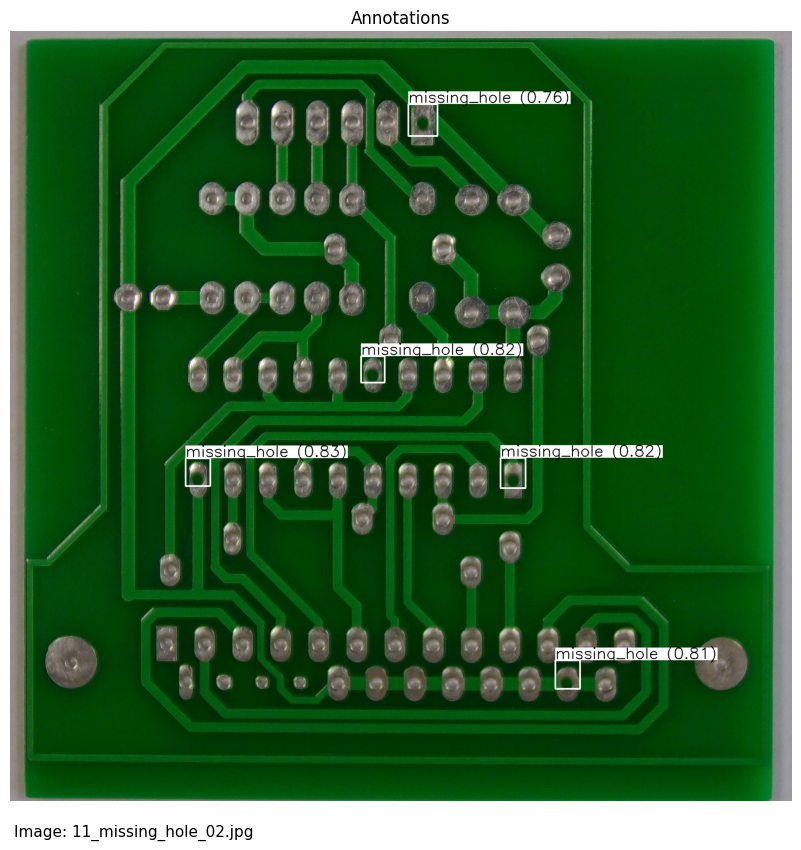

In [95]:
visualize_annotations('11_missing_hole_02.jpg', images_dir, pred_annot_df, is_subfolder=True);

In [97]:
model.export()

Ultralytics 8.3.232 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon CPU @ 2.00GHz)

PyTorch: starting from '/kaggle/working/results/weights/best.pt' with input shape (1, 3, 832, 832) BCHW and output shape(s) (1, 10, 14196) (49.7 MB)

TorchScript: starting export with torch 2.1.2...
TorchScript: export success ✅ 6.9s, saved as '/kaggle/working/results/weights/best.torchscript' (99.2 MB)

Export complete (9.1s)
Results saved to /kaggle/working/results/weights
Predict:         yolo predict task=detect model=/kaggle/working/results/weights/best.torchscript imgsz=832  
Validate:        yolo val task=detect model=/kaggle/working/results/weights/best.torchscript imgsz=832 data=/kaggle/working/data.yaml  
Visualize:       https://netron.app


'/kaggle/working/results/weights/best.torchscript'

In [100]:
import os
from IPython.display import FileLink

# 1. CLEANUP: Delete ALL old zip files to free up massive space
print("🧹 Cleaning up old zip files...")
!rm -f *.zip
!rm -f *.7z
print("✅ Cleanup done.")

# 2. ZIP EVERYTHING: 'output', 'runs', and 'results' together
# We use -q (quiet) to prevent freezing
# We exclude 'predict' images from runs if they are huge to save space (Optional)
print("📦 Zipping 'output', 'runs', and 'results'... this may take 2-3 minutes.")

# This command zips all 3 folders into 'final_data.zip'
!zip -r -q final_data.zip output runs results

# 3. VERIFY & DOWNLOAD
if os.path.exists("final_data.zip"):
    size_mb = os.path.getsize("final_data.zip") / (1024 * 1024)
    print(f"\n✅ SUCCESS! Zip created ({size_mb:.2f} MB).")
    print("Click the link below to download:")
    display(FileLink('final_data.zip'))
else:
    print("\n❌ Error: Zip creation failed. You might be completely out of space.")
    print("Try deleting the 'runs' folder if you don't need the prediction images.")

🧹 Cleaning up old zip files...
✅ Cleanup done.
📦 Zipping 'output', 'runs', and 'results'... this may take 2-3 minutes.

✅ SUCCESS! Zip created (3634.83 MB).
Click the link below to download:


/kaggle/working/final_data.zip

# Code below to test custom images

In [68]:
# Input images (still located inside /kaggle/input/)
custom_img_dir = os.path.join(root_dir, 'PCB_DATASET/custom_images')

# Output must be inside /kaggle/working/
resized_custom_img_dir = '/kaggle/working/custom_images_resize'

resize_images(custom_img_dir, resized_custom_img_dir)


In [70]:
model = YOLO('/kaggle/working/pcb_m_single_sota/run_m_sota/weights/best.torchscript')
01.jpg')

image_path = os.path.join(resized_custom_img_dir, 'result_custom = model(image_path, imgsz=768, conf=0.25, save=True, save_txt=True, save_conf=True)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /kaggle/working/pcb_m_single_sota/run_m_sota/weights/best.torchscript for TorchScript inference...



FileNotFoundError: /kaggle/working/custom_images_resized/01.jpg does not exist

In [ ]:
predict_dir = '/content/runs/detect/predict2'
dest_custom_predict_dir = os.path.join(custom_img_dir, 'results/predict')

shutil.copytree(predict_dir, dest_custom_predict_dir)

# Gradio Gui

In [98]:
import gradio as gr
from ultralytics import YOLO
import cv2
import os

# === Load trained YOLOv8 model ===
model_path = '/kaggle/working/results/weights/best.torchscript'  # update if needed
assert os.path.exists(model_path), f"❌ Model not found at {model_path}"
model = YOLO(model_path)

# === Detection function ===
def detect_pcb_defects(image):
    # Run YOLOv8 inference
    results = model.predict(source=image, save=False, conf=0.15, imgsz=768)
    # Extract annotated image
    annotated_img = results[0].plot()  # returns numpy array (BGR)
    
    # Convert BGR → RGB for display
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    return annotated_img

# === Gradio UI ===
title = "🔍 PCB Defect Detection using YOLOv8"
description = (
    "Upload a PCB image to detect defects such as missing holes, open circuits, "
    "mouse bites, shorts, and spurious copper using a trained YOLOv8 model."
)

demo = gr.Interface(
    fn=detect_pcb_defects,
    inputs=gr.Image(type="filepath", label="Upload PCB Image"),
    outputs=gr.Image(label="Detection Result"),
    title=title,
    description=description,
    examples=[
        ["/home/arm/Downloads/PCB/example_images/pcb1.png"],
        ["/home/arm/Downloads/PCB/example_images/pcb2.png"]
    ],
)

if __name__ == "__main__":
    demo.launch(server_name="0.0.0.0", server_port=None)

ModuleNotFoundError: No module named 'gradio'